In [1]:
import pystan
import numpy as np
import pandas as pd
import scipy.stats as stats
import matplotlib.pyplot as plt

from matplotlib import rc
plt.rc('text', usetex=True)

/home/gianluca/.virtualenvs/bayes/lib/python3.5/site-packages/Cython/Distutils/old_build_ext.py:30: UserWarning: Cython.Distutils.old_build_ext does not properly handle dependencies and is deprecated.
  "Cython.Distutils.old_build_ext does not properly handle dependencies "


# Baseball example

This model tries to estimate the batting average (also abbreviated AVG) in the MLB league in the 2012 season. We are trying to estimate both the player's performance ($\theta_{i}$) and the position performance ($\omega_{c}$). 

$$
\begin{align*}
y_{i,s|c} &\sim Binomial(N_{s|c}, \theta_{s|c}) \quad \text{ where } \quad s \in [0, S] \quad \text{ and } \quad c \in [0, C]\\
\theta_{s|c} &\sim Beta(\omega_{c} * (\kappa_{c} - 2) + 1, (1 - \omega_{c})*(\kappa_{c} - 2) + 1) \\
\kappa_{c} &\sim Gamma(S_{\kappa}, R_{\kappa}) \\
\omega_{c} &\sim Beta(\omega * (\kappa - 2) + 1, (1 - \omega)*(k - 2) + 1) \\
\omega &\sim Beta(A_{\omega}, B_{\omega}) \\
\kappa &\sim Gamma(S_{\kappa}, R_{\kappa}) \\
\end{align*}
$$

The key point here is that we are using a Binomial likelihood function and are using a Beta prior for each player's ability at batting. This Beta prior is however conditional to the player's position on the field, so the $\alpha$ and $\beta$ parameters for the prior are shared among players of the same role.

Another important fact is that we are using a re-parametrization of the Beta distribution. Instead of using the popular $\alpha$ and $\beta$ parameters, we are using:

$$
\begin{align*}
\alpha &= \omega * (\kappa - 2) + 1 \\
\beta &= (1 - \omega)*(\kappa - 2) + 1
\end{align*}
$$

Where $\omega$ represents the mode of the Beta distribution and $\kappa$ the concentration parameter. This reparametrization is useful because we are interested in having an estimate for how close the perfomance are for players of the same role. In this way we can easily assess if the with-in group variance differs from the nine groups of players.

Lastly, we set priors for the parameters $\omega$ and $\kappa$. This is useful for two reasons. First we didn't have to hard-code them and let the model estimate the more likely parameters based on the data and the model itself. Second, we can estimate the league level values for $\omega$ and $\kappa$. This could be useful if we want to make inferences on new players, or want to compare MLB players performance against players of a different league. The latter comparison of course should be taken cautiosly since doesn't really consider the pitchers' ability. Another league could in fact have way higher AVG, simply because the quality of the pitchers playing in that league is poor.

For details about the model, please consult the book.

In [2]:
baseball = pd.read_csv('./data/BattingAverage.csv')
baseball = baseball.sort_values('PriPosNumber').reset_index(drop=True)
baseball.head()

,Player,PriPos,Hits,AtBats,PlayerNumber,PriPosNumber
0,Fernando Abad,Pitcher,1,7,1,1
1,Brad Lincoln,Pitcher,2,10,511,1
2,Tim Lincecum,Pitcher,4,45,510,1
3,Ted Lilly,Pitcher,1,15,508,1
4,Colby Lewis,Pitcher,2,4,504,1


Before jumping into the modelling part, we are going to check for presence of duplicates in the dataset and corrupted data.

In [3]:
# check if there are duplicates in the dataset
if baseball.shape[0] == baseball.Player.nunique():
    print('Okay')
else:
    print('Presence of duplicate players')
    print(baseball.shape[0], baseball.Name.nunique())

Okay


In [4]:
# check if any player has more Hits recorded than AtBats 
if all(baseball.AtBats.values - baseball.Hits.values < 0):
    print('Presence of faulty measurements')
else:
    print('Okay')

Okay


The following chunk will extract the necessary data to fit our model, and organise it in a digestible form for Stan.

In [5]:
at_bat = baseball.AtBats.values
hits = baseball.Hits.values
positions = baseball.PriPosNumber.values
n_positions = baseball.PriPosNumber.nunique()

counts = baseball.groupby('PriPosNumber').PlayerNumber.count()
start = [1]
for idx, count in enumerate(counts):
    starting_point = start[idx] + count
    start.extend([starting_point])
    
length = [start[idx+1] - start[idx] for idx in range(len(start)-1) ]

variables = [at_bat, hits, positions, n_positions, start, length]
for variable in variables:
    print(variable)

[  7  10  45  15   4   5   1  64   1  12  61  65   9   3   1  53   1  20
  58  51  36  33  10  28  13  53   5   2   1  11   1   3   1   2   3  33
   5   4  49   2   1   4   4  64   1   2   3   1  32  38   2  63  50  38
  11   4   1   2  57   2   2  33   1   6  64   9   4   1  17  27   8  30
  40  25   1   8  25  31   1   2   7  32   2   4   1  40  32  67   3  53
  69   5   2   1  55  13   2   5   1   1   4   3   1   1   2   1  20   1
  18   5  59   4  56  32  49   1   1   4  65   3   5   5   9   5   5   1
   2  10  28  47   1   1   6   1  14   7   5  13   4   2   1   2  35  35
   4   5  30   1   4   5   4   2  57   4  34   2   2  37  53   1  40   5
   4   8  28  49  12   4  12   5   1   2   1   6  66  28  56  54   1  50
   1   2   5   5   2   1   6   1   2  12   9   1  16   2   7   6  50   4
  55  18   3  13   1  11  13   1   2   4  55  56   1  11   1   1  12   2
   2   3   5  14   3  12  61   3   1   2  69   3   3   1   1   3   1  10
   3   4   2  26   4   1   1   1   1   1   7  68   

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_1d34d6dc95a81207bc6e7bb00bca3620 NOW.


Time taken to run the model: 0:05:11.281997
Inference for Stan model: anon_model_1d34d6dc95a81207bc6e7bb00bca3620.
4 chains, each with iter=5000; warmup=2500; thin=1; 
post-warmup draws per chain=2500, total post-warmup draws=10000.

                   mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
omega0             0.23  2.6e-4   0.02   0.18   0.21   0.23   0.24   0.27   6903    1.0
omega[0]           0.12  2.5e-4 6.5e-3   0.11   0.12   0.12   0.13   0.13    701   1.01
omega[1]           0.24  8.4e-5 5.3e-3   0.23   0.23   0.24   0.24   0.25   4017    1.0
omega[2]           0.25  7.2e-5 4.8e-3   0.24   0.25   0.25   0.25   0.26   4471    1.0
omega[3]           0.25  8.2e-5 5.2e-3   0.24   0.25   0.25   0.25   0.26   3989    1.0
omega[4]           0.25  8.5e-5 5.4e-3   0.24   0.25   0.26   0.26   0.27   4111    1.0
omega[5]           0.25  8.8e-5 5.6e-3   0.24   0.24   0.25   0.25   0.26   4088    1.0
omega[6]           0.25  8.0e-5 5.0e-3   0.24   0.25   0.25   

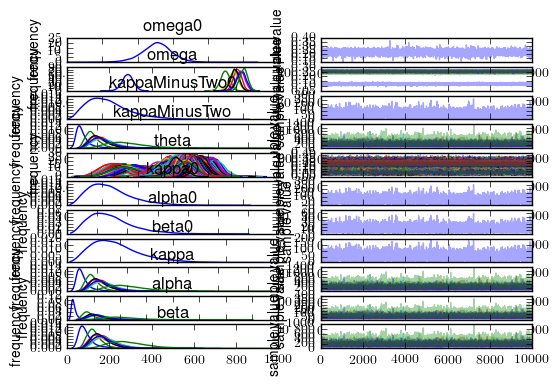

In [6]:
baseball_data = {
    'P': baseball.shape[0],
    'positions': positions,
    'start': start,
    'length': length,
    'N_positions': n_positions,
    'N': at_bat,
    'y': hits,
    'S': 0.01,
    'R': 0.01,
    'A': 1,
    'B': 1
}

import datetime
start_dt = datetime.datetime.now()
fit = pystan.stan(file='baseball.stan', data=baseball_data,
                   iter=5000, chains=4)
end_dt = datetime.datetime.now()
print("Time taken to run the model: {}".format(end_dt - start_dt))

print(fit)
fit.plot()
plt.show()

Let's dig a bit into the results, and in particular compare the group level estimates to answer questions like: *"Are MLB pitchers worst than catches at batting?"*

In [7]:
baseball.groupby(['PriPosNumber', 'PriPos']).Player.nunique()

PriPosNumber  PriPos      
1             Pitcher         324
2             Catcher         103
3             1st Base         81
4             2nd Base         72
5             3rd Base         75
6             Shortstop        63
7             Left Field      103
8             Center Field     67
9             Right Field      60
Name: Player, dtype: int64

Looking at the results we can notice that *pitchers* are pretty bad at batting. They are consistently poorer hitters than any other player in a different role. We can assess what is the probability of *pitchers* to be worst on average than *catchers* (the second worst category.

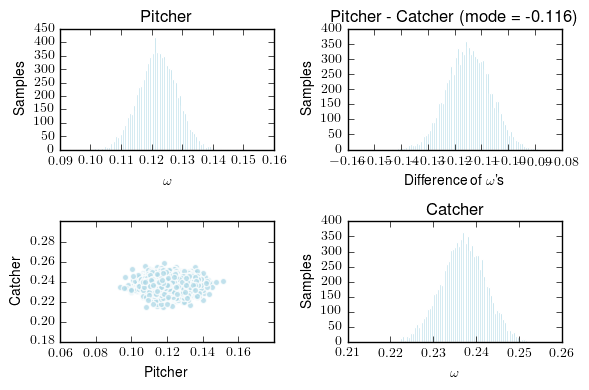

In [35]:
pitchers = fit.extract()['omega'][:,0]
catchers = fit.extract()['omega'][:,1]

diff = pitchers - catchers
mode = stats.mode([round(i, 3) for i in diff])

plt.subplot(2,2,1)
plt.hist(pitchers, bins=100, color='lightblue', edgecolor='white')
plt.title('Pitcher')
plt.xlabel(r'$\omega$'); plt.ylabel('Samples')

plt.subplot(2,2,2)
plt.hist(diff, bins=100, color='lightblue', edgecolor='white')
plt.xlabel(r"Difference of $\omega$'s"); plt.ylabel('Samples')
plt.title('Pitcher - Catcher (mode = {})'.format(mode[0][0]))

plt.subplot(2,2,3)
plt.scatter(pitchers, catchers, marker='o', color='lightblue', edgecolor='white', alpha=.75)
plt.xlabel('Pitcher')
plt.ylabel('Catcher')

plt.subplot(2,2,4)
plt.hist(catchers, bins=100, color='lightblue', edgecolor='white')
plt.title('Catcher')
plt.xlabel(r'$\omega$'); plt.ylabel('Samples')

plt.tight_layout()
plt.show()

In [22]:
p = np.mean(diff < 0)
print('The probability of catchers being better than pitchers at batting is {0:.0%}'.format(p))

The probability of catchers being better than pitchers at batting is 100%


It's probably more interesting to compare the best groups of players, since their posterior distributions look very close. In this case we are comparing Center Field against Right Field.

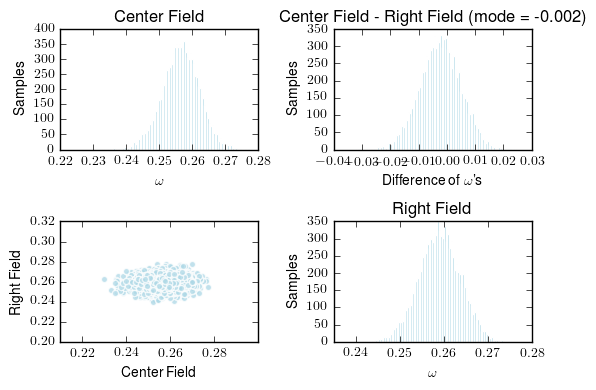

In [36]:
centerfield = fit.extract()['omega'][:,7]
rightfield = fit.extract()['omega'][:,8]

diff = centerfield - rightfield
mode = stats.mode([round(i, 3) for i in diff])

plt.subplot(2,2,1)
plt.hist(leftfield, bins=100, color='lightblue', edgecolor='white')
plt.title('Center Field')
plt.xlabel(r'$\omega$'); plt.ylabel('Samples')

plt.subplot(2,2,2)
plt.hist(diff, bins=100, color='lightblue', edgecolor='white')
plt.xlabel(r"Difference of $\omega$'s"); plt.ylabel('Samples')
plt.title('Center Field - Right Field (mode = {})'.format(mode[0][0]))

plt.subplot(2,2,3)
plt.scatter(centerfield, rightfield, marker='o', color='lightblue', edgecolor='white', alpha=.75)
plt.xlabel('Center Field')
plt.ylabel('Right Field')

plt.subplot(2,2,4)
plt.hist(rightfield, bins=100, color='lightblue', edgecolor='white')
plt.title('Right Field')
plt.xlabel(r'$\omega$'); plt.ylabel('Samples')

plt.tight_layout()
plt.show()

In [33]:
p = np.mean(diff < 0)
print('The probability of Left Field being better than Right Field at batting is {0:.0%}'.format(p))

The probability of Left Field being better than Right Field at batting is 63%
